In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [26]:
# load csv
df = pd.read_csv("train_processed.csv", index_col=0)

# place the attrition column at the end
df = df[[col for col in df.columns if col != 'Attrition'] + ['Attrition']]
df.head()

,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition
Age,,,,,,,,,,,,,,,,,,,,,
41,1102,1,2,1,1,2,1,94,3,2,...,0,0,0,0,1,0,0,0,1,1
49,279,8,1,1,2,3,0,61,2,2,...,0,0,0,1,0,0,0,1,0,0
37,1373,2,2,1,4,4,0,92,2,1,...,0,0,0,0,0,0,0,0,1,1
33,1392,3,4,1,5,4,1,56,3,1,...,0,0,0,1,0,0,0,1,0,0
27,591,2,1,1,7,1,0,40,3,1,...,0,0,0,0,0,0,0,1,0,0


Dataset size: 1058


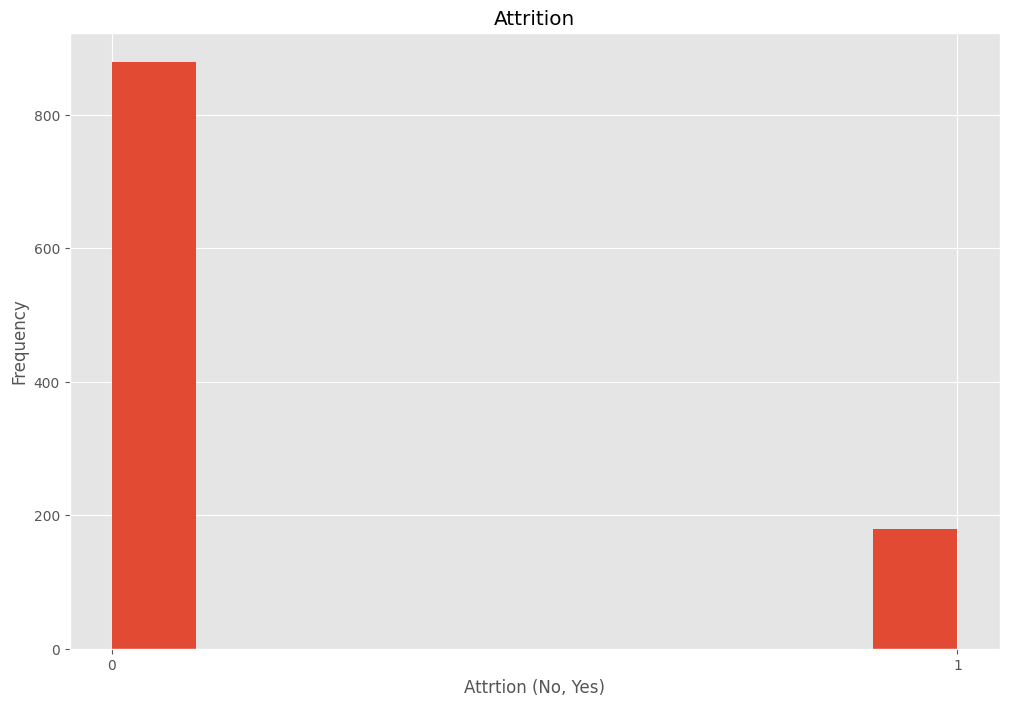

In [27]:
print("Dataset size:", len(df))
df['Attrition'].hist();
plt.title('Attrition')
plt.xlabel('Attrtion (No, Yes)')
plt.ylabel('Frequency')
plt.xticks([0,1]);

In [28]:
# more statistics
df.describe()

,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition
count,1058.000000,1058.000000,1058.000000,1058.0,1058.000000,1058.000000,1058.000000,1058.000000,1058.00000,1058.000000,...,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000
mean,809.542533,8.978261,2.879017,1.0,731.753308,2.712665,0.413989,65.643667,2.73724,2.090737,...,0.074669,0.101134,0.058601,0.202268,0.219282,0.054820,0.228733,0.438563,0.332703,0.169187
std,408.478049,8.040608,1.031442,0.0,431.418209,1.092959,0.492779,20.324861,0.70473,1.136514,...,0.262981,0.301649,0.234988,0.401881,0.413956,0.227737,0.420216,0.496446,0.471404,0.375094
min,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,30.000000,1.00000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,465.250000,2.000000,2.000000,1.0,364.500000,2.000000,0.000000,48.000000,2.00000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,817.500000,7.000000,3.000000,1.0,723.500000,3.000000,0.000000,65.000000,3.00000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1168.500000,13.000000,4.000000,1.0,1101.750000,4.000000,1.000000,83.000000,3.00000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1499.000000,29.000000,5.000000,1.0,1487.000000,4.000000,1.000000,100.000000,4.00000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,1:-1]
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)


(1058, 51)
(1058,)
(1058,)


In [32]:
print(y)

[1 0 1 ... 0 1 1]


In [30]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_52721/822795065.py:4: RuntimeWarning: invalid value encountered in divide
  X = (X - X_mean) / X_std


Split data into train and test

In [31]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


In [16]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    print("alpha shape:", alpha.shape)  # Should be [n_cat]
    print("beta shape:", beta.shape)    # Should be [D, n_cat]
    print("X shape:", X.shape)          # Should be [N, D]
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [23]:
n_cat = 2  # number of categories
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_52721/2546918915.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
/var/folders/sc/psz6mjj950s5rt5xd9vb12tc0000gn/T/ipykernel_52721/2546918915.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()


In [24]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

alpha shape: torch.Size([1, 2])
beta shape: torch.Size([51, 2])
X shape: torch.Size([698, 51])


ValueError: Expected parameter logits (Tensor of shape (698, 2)) of distribution Categorical(logits: torch.Size([698, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]])
Trace Shapes:       
 Param Sites:       
Sample Sites:       
   alpha dist |  1 2
        value |  1 2
    beta dist | 51 2
        value | 51 2
Trace Shapes:
 Param Sites:
Sample Sites:

Upon convergence, we can use the ```Predictive``` class to extract samples from posterior:

In [25]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

Plot posterior distributions for the parameters using the ```seaborn``` package:

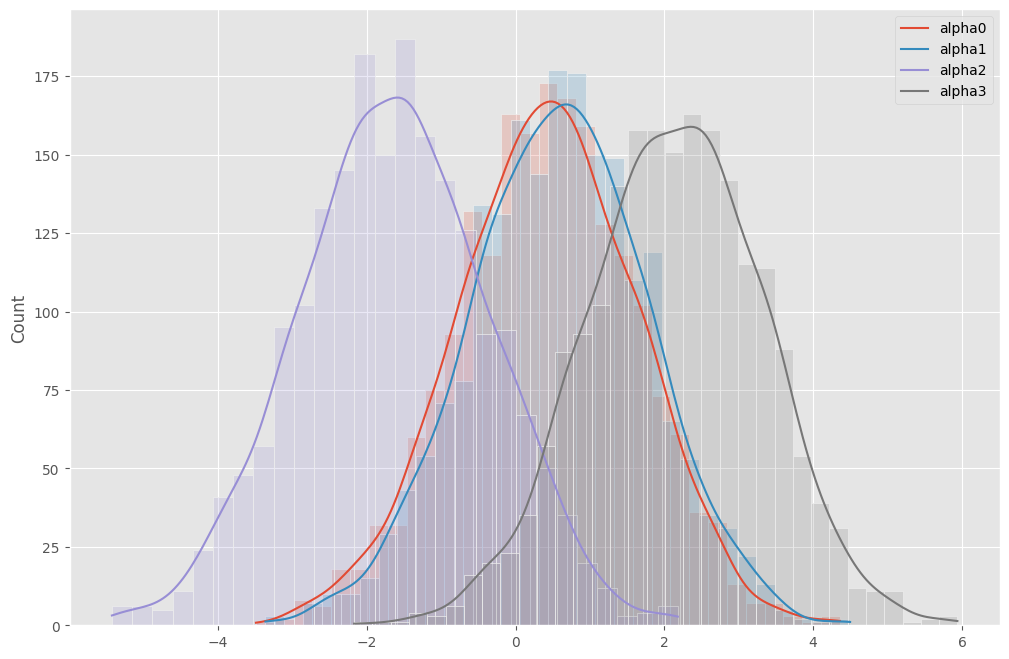

In [26]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

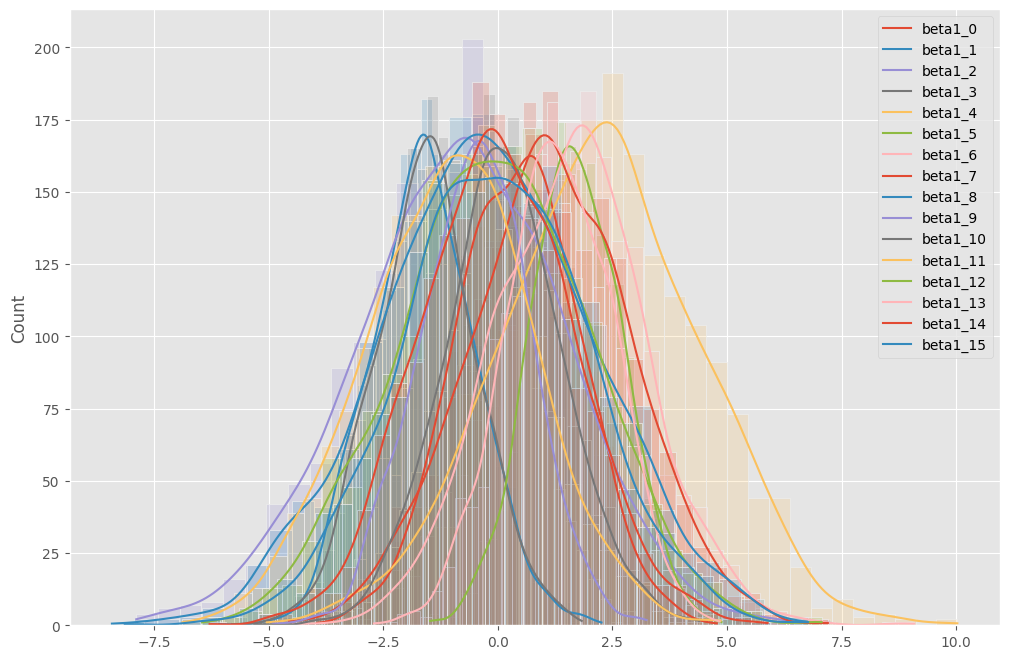

In [27]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

We can now use the inferred posteriors to make predictions for the testset and compute the corresponding accuracy:

In [28]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [29]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 1 4 4 4 3 1 2 2 1 4 2 1 2 4 4 4 4 2 4 1 4 2 2 4 4 4 4 3 4 4
 3 2 1 4 2 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 2 3 2 4 2 4 4 4 3 2 1 2 4 4 4
 4 4 1 2 4 2 4 4 1 4 3 4 4 4 1 4 3 1 4 2 1 4 1 1 4 4 1 1 4 1 3 4 4 4 4 4 4
 4 4 1 3 1 1 4 3 2 4 1 4 2 1 1 4 2 2 4 4 4 1 4]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6791044776119403
